# Exploratory Data Analysis: Stock Market

In this notebook we will analyze the historical daily price and volume data for all US based stocks and ETFs made available on [Kaggle](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data). The goal is to understand the structure of the data, identify any potential issues or characteristics and lay the groundwork for predictive modeling.

### 1. Setup and Imports

In [10]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.errors import EmptyDataError

sns.set_theme(style="whitegrid")
plt.style.use("fivethirtyeight")

base_path = "../data/raw/Data/Stocks/"

### 2. Data overview

The dataset is distributed into many individual `.txt` files, each representing a single stock ticker. The first step will be to aggregate the data into a single DataFrame, and hopefully get a comprehensive view.

In [11]:
all_files = glob.glob(os.path.join(base_path, "*.us.txt"))

df_list = []
for file in all_files:
    try:
        temp_df = pd.read_csv(file)
        ticker = os.path.basename(file).split('.us.txt')[0]
        temp_df['Ticker'] = ticker
        df_list.append(temp_df)
    except EmptyDataError as e:
        print(f'Skipping empty file: {os.path.basename(file)}')
        continue

df = pd.concat(df_list, ignore_index=True)

print('Data Information:')
df.info()

print('First five rows:')
print(df.head())

print('Summary Statistics:')
print(df.describe())

Skipping empty file: pbio.us.txt
Skipping empty file: accp.us.txt
Skipping empty file: amrh.us.txt
Skipping empty file: vist.us.txt
Skipping empty file: srva.us.txt
Skipping empty file: bbrx.us.txt
Skipping empty file: bolt.us.txt
Skipping empty file: amrhw.us.txt
Skipping empty file: znwaa.us.txt
Skipping empty file: stnl.us.txt
Skipping empty file: hayu.us.txt
Skipping empty file: otg.us.txt
Skipping empty file: molc.us.txt
Skipping empty file: boxl.us.txt
Skipping empty file: sbt.us.txt
Skipping empty file: fmax.us.txt
Skipping empty file: rbio.us.txt
Skipping empty file: wnfm.us.txt
Skipping empty file: jt.us.txt
Skipping empty file: pxus.us.txt
Skipping empty file: vmet.us.txt
Skipping empty file: asns.us.txt
Skipping empty file: sfix.us.txt
Skipping empty file: scci.us.txt
Skipping empty file: sail.us.txt
Skipping empty file: wspt.us.txt
Skipping empty file: scph.us.txt
Skipping empty file: gnst.us.txt
Skipping empty file: send.us.txt
Skipping empty file: bxg.us.txt
Skipping empt

One thing that can be quickly noticed is that the OpenInt column is all zeros for the first five rows. Let's check if that holds true for all entries.

In [12]:
is_all_zero = (df['OpenInt'] == 0).all()
print(f'Is column `OpenInt` all zeros? {is_all_zero}')

Is column `OpenInt` all zeros? True


Bittersweet news: while we can safely remove it, what we hoped would be valuable information turned out to be just empty data.

Before moving on, the Date column seems to be object type, a string. This might be a problem leaving it as is, and it might prevent our model from training correctly and understanding the time-series nature of the data.

### 3. Data cleaning and Preprocessing

Based on our initial findings, let's perform some necessary cleaning steps to prepare the data for analysis.

In [13]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop('OpenInt', axis=1)
df.set_index('Date', inplace=True)

print('Data after cleaning, first five rows:')
print(df.head())

Data after cleaning, first five rows:
              Open    High     Low   Close  Volume Ticker
Date                                                     
2005-02-25  12.868  12.982  12.834  12.834   15928    iba
2005-02-28  13.536  13.536  13.273  13.281   16382    iba
2005-03-01  13.185  13.299  13.185  13.299    1250    iba
2005-03-02  13.361  13.395  13.273  13.291    8760    iba
2005-03-03  13.361  13.404  12.966  13.218    9897    iba


### 4. Exploring key Tickers

Let's now focus on the most important part of this notebook, visualizing the data to understand its behaviour. We will focus on just a couple of well known tickers Apple (aapl) and Google (googl) to get a feel for the trends.

#### Closing price over time

This plot helps us visualize the long-term price and compare the performance of different stocks.

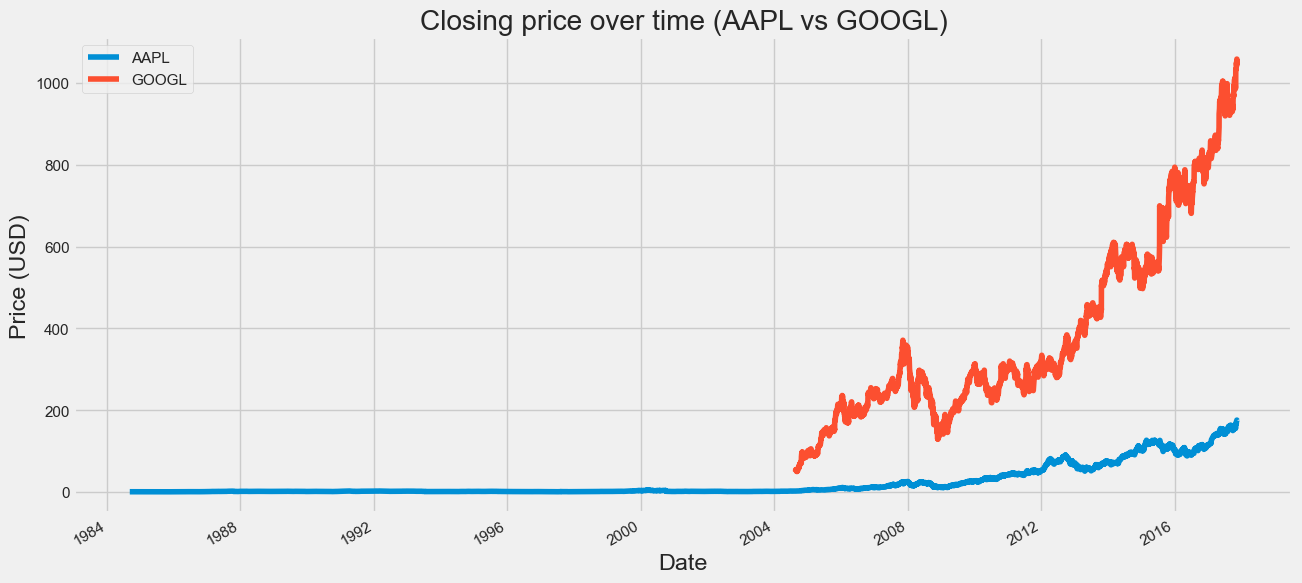

In [20]:
plt.figure(figsize=(14, 7))
plt.title('Closing price over time (AAPL vs GOOGL)')
plt.ylabel('Price (USD)')

df[df['Ticker'] == 'aapl']['Close'].plot(label='AAPL', legend=True)
df[df['Ticker'] == 'googl']['Close'].plot(label='GOOGL', legend=True)

plt.show()

So let's break down what was plotted above. The historical data goes from way back in 1984 to 2018. Both exhibit bullish(upward) long-term trend, which indicates significant company growth and positive investor returns. Apple's data spans a much longer period, starting  actually in 1980. Google's data begins around in 2004.

But let's take a step back, and see the role of the two tickers. The data is a time series with clear trends. Volatility is a core feature. One very important aspect is that the price and volume (not shown here) are on vastly different scaled, which tells us that normalization is a must.

An important point, and maybe the most, is that the two tickers look very different. The individuality of each ticker is a core feature of the problem. Our goal is not build a model that can predict GOOGL's price. The strategy is to create a generalizable model, that can take historical data of any ticker as input and produce a meaningful output forecast.

The patterns we can see in AAPL and GOOGL, like trends and volatility, tell us what kinds of features we should engineer for every stock. Our data preprocessing should include a computation of things like moving averages, rolling volatility and momentum indicators for each ticker individually.

And lastly because looking at individual stocks is limiting, it forces the next step to be aggregate analysis. We will continue with that in the next sections, by looking at volatility, volume, performance and outliers.

### 5. Volatility and volume analysis

As mentioned before we will move to the big picture. The goal will be to analyze the entire dataset to identify any market-wide patterns, distributions and outliers.

#### Volatility analysis: most and least volatile stocks

Volatility is a measure of risk. We can identify the most and least volatile stocks by computing the standard deviation of their daily returns. A higher standard deviation implies more price swings.

Top 10 most volatile stocks:
Ticker
mtbcp    614.028595
cxdc      33.031215
cbx        7.408526
cbo        4.475033
hlg        4.258471
inpx       3.235539
ibo        2.572796
bxp        1.755719
avb        1.744120
slg        1.740207
Name: Daily Return, dtype: float64
Top 10 least volatile stocks:
Ticker
jdiv   NaN
jhsc   NaN
jmom   NaN
omfl   NaN
omfs   NaN
pmom   NaN
ppdf   NaN
pval   NaN
sogo   NaN
vtc    NaN
Name: Daily Return, dtype: float64


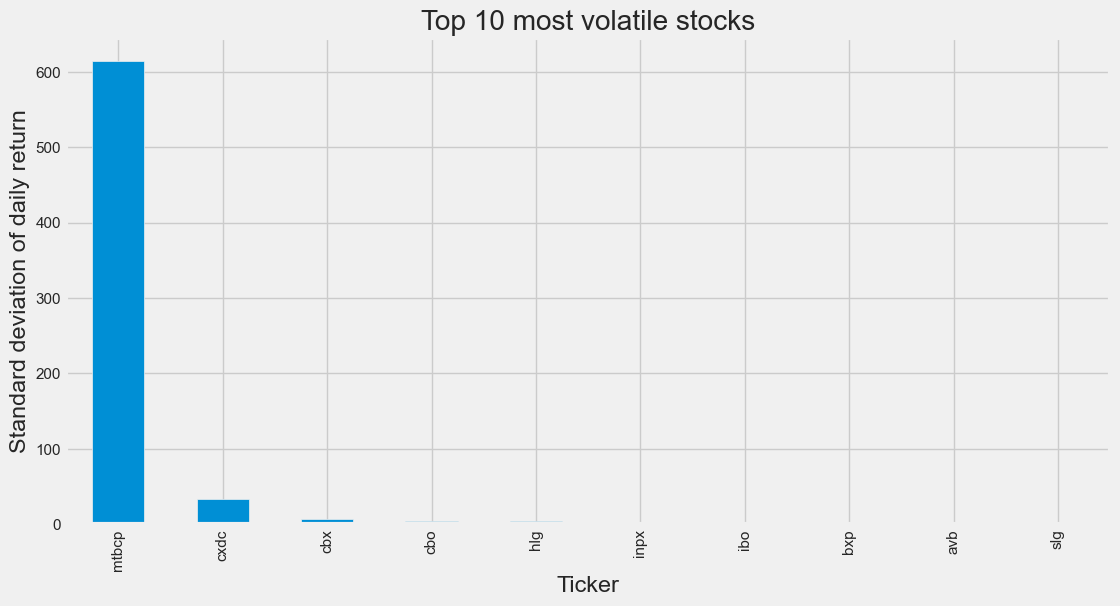

In [24]:
df['Daily Return'] = df.groupby('Ticker')['Close'].pct_change()
volatility = df.groupby('Ticker')['Daily Return'].std().sort_values(ascending=False)

print("Top 10 most volatile stocks:")
print(volatility.head(10))

print("Top 10 least volatile stocks:")
print(volatility.tail(10))

plt.figure(figsize=(12, 6))
volatility.head(10).plot(kind='bar')
plt.title('Top 10 most volatile stocks')
plt.xlabel('Ticker')
plt.ylabel('Standard deviation of daily return')
plt.show()

Such high volatility results are extreme statistical outliers that point to data quality issues, not market volatility. A standard deviation of 614 implies an average daily price change of 61400%. This is a sign of corrupt or unadjusted data. But for a better estimate let's plot the closing prices over time.

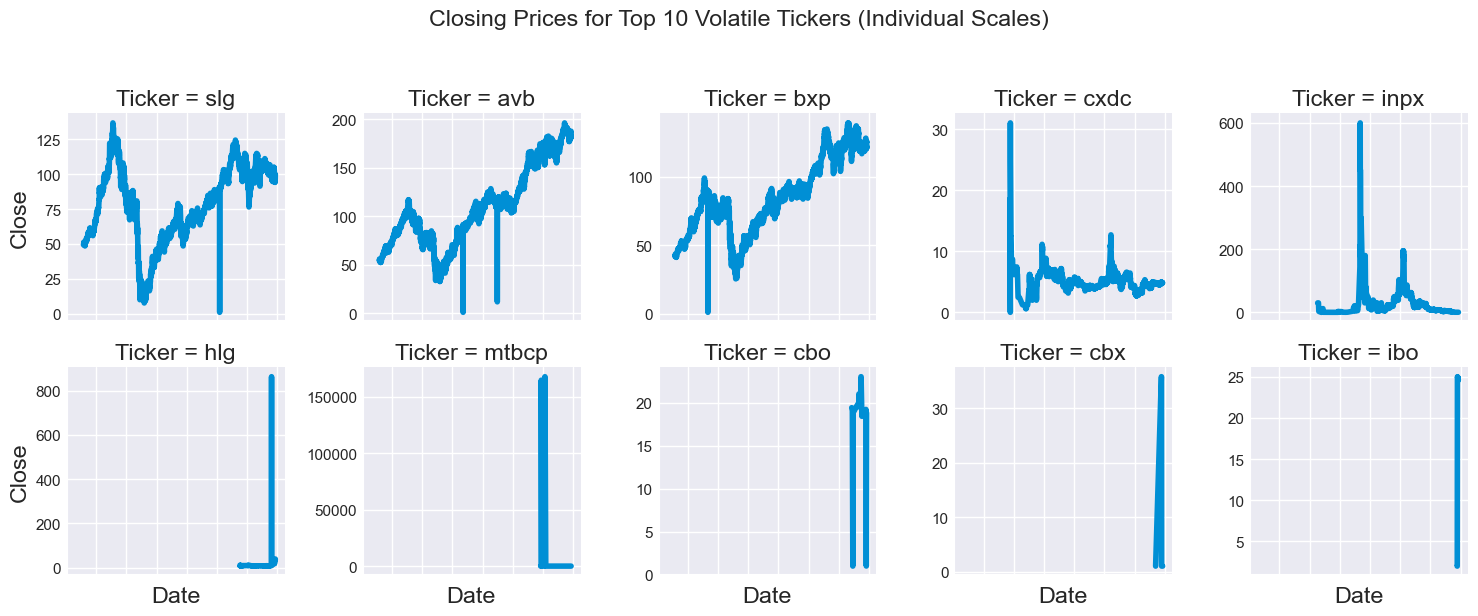

In [34]:
top_ten_volatile_tickers = volatility.head(10).index
df_subset = df[df['Ticker'].isin(top_ten_volatile_tickers)].reset_index()

g = sns.FacetGrid(df_subset, col='Ticker', col_wrap=5, sharey=False, height=3)
g.map(plt.plot, "Date", "Close")

g.set_xticklabels(rotation=45)
g.fig.suptitle('Closing Prices for Top 10 Volatile Tickers (Individual Scales)', y=1.03)
plt.tight_layout()
plt.show()

From the multifacet plot above we can identify two different types of data problems. One is unsalvageable(second row) while the other has zero value outliers(first row).

To have a price that is near or zero then a spike to an absurd value and back to near zero, it isn't plain possible on real markets. This is fundamentally corrupt and unusable data. These tickers will be removed entirely.

Now about the zero value outliers. The pattern for the first row is different and suggest a fix. The overall price history looks legitimate, but has sudden single day drops to zero. This could be missing data being incorrectly filled with a zero. However, the last two here will be excluded as well. The second to last, has a deviation of 33, which here means a 3300% increase, while it may not be a data error, its behavior is so extreme that it's an outlier. For a generalizable model a ticker like this provides noise rather than signal. As for the last one, here we have huge jumps from near 0 to 600, maybe a reverse stock split, where the company consolidated its shares, causing the huge price jump.

Now before we move on, we should also talk a bit about the least volatile stocks. There are tickers for which we have at most two rows, which produce NaN values. Files that contain one or two rows are likely to be of any value for analysis and can be considered noise. These files lack sufficient information for training a model.

In [36]:
two_row_or_less_file_count=0
for file in all_files:
    try:
        temp_df = pd.read_csv(file)

        if len(temp_df) <= 2:
            two_row_or_less_file_count += 1
    except EmptyDataError:
        continue

print(f'Number of files with maximum two rows={two_row_or_less_file_count}')

Number of files with maximum two rows=21


A model cannot learn any trend, pattern or seasonality from two data points. To a model, these files will represent random noise, not signal. Including them will most probably degrade performance.

#### Volume analysis: distribution of trading activity

Next let's take a look at the average daily trading volume for every stock. This will tell use if our dataset contains heavily-traded blue chip stocks or is dominated by thinly traded ones.

Top 10 most traded stocks (by Average daily volume):
Ticker
aapl    1.066416e+08
msft    7.945800e+07
csco    7.146959e+07
intc    5.646601e+07
bac     5.441999e+07
siri    4.922371e+07
orcl    4.453661e+07
ebay    4.129841e+07
fb      3.770716e+07
s       3.672811e+07
Name: Volume, dtype: float64


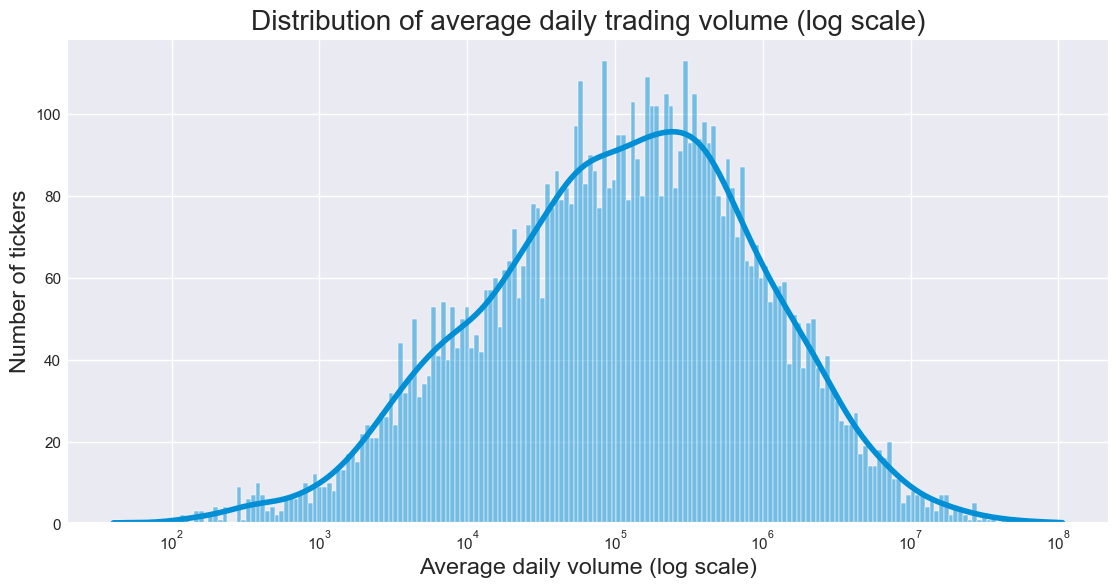

In [37]:
average_volume = df.groupby('Ticker')['Volume'].mean().sort_values(ascending=False)

print("Top 10 most traded stocks (by Average daily volume):")
print(average_volume.head(10))

plt.figure(figsize=(12, 6))
sns.histplot(average_volume, bins=200, kde=True, log_scale=True)
plt.title('Distribution of average daily trading volume (log scale)')
plt.xlabel('Average daily volume (log scale)')
plt.ylabel('Number of tickers')
plt.show()

The x-axis here is on log scale. The fact that the histogram appears bell-shaped curve on a log scale indicates that the underlying distribution of the average daily trading is log-normal. This indicates that a very small number of stocks have extremely high trading volumes, while the vast majority is much less actively traded. This is a critical insight for modeling, features like volume need to be log normalized to be useful.